(non_linear_coupling)=
# Non-linear value coupling between continuous state nodes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/1.4-Continuous_HGF_non_linear_value_coupling.ipynb)

```{tip} Authors
- Kora Tristan, Aarhus University, Denmark (kora.montemagno@cas.au.dk)
- Nicolas Legrand, Aarhus University, Denmark (nicolas.legrand@cas.au.dk)
```

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax import lax

from pyhgf.model import Network

plt.rcParams["figure.constrained_layout.use"] = True

np.random.seed(43)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


When using value coupling in previous examples, the coupling function $g$ between nodes was assumed to be linear (in the form of $g(x) = Ax + B$). This assumes linear influence of the belief parent. Since both the belief update step and the prediction step use either the first and second-order derivatives of the coupling function $g'$ and $g''$ or the function itself, in the case of a linear coupling the equations for prediction and updates of continuous state nodes can be simplified, as $x$ disappears during the derivation process.

However, different coupling functions between value parents and children could be used to model different kinds of stochastic processes. In PyHGF, if coupling functions between nodes are not specified, the default equations are the simplified ones (in which the coupling function is assumed to be the identity function), but it is possible to manually input any other functions in the parent node when building the network, as long as it is two times differentiable in JAX. In this notebook, we illustrate how to do it and provide some relevant examples.

## ReLU (rectified linear unit) activation function

For this tutorial, we will try to fit a 2-level continuous HGF to some data that are expected to behave in a known non-linear way. Let's consider a signal $u_1$ consisting of a Gaussian random walk with some drift.

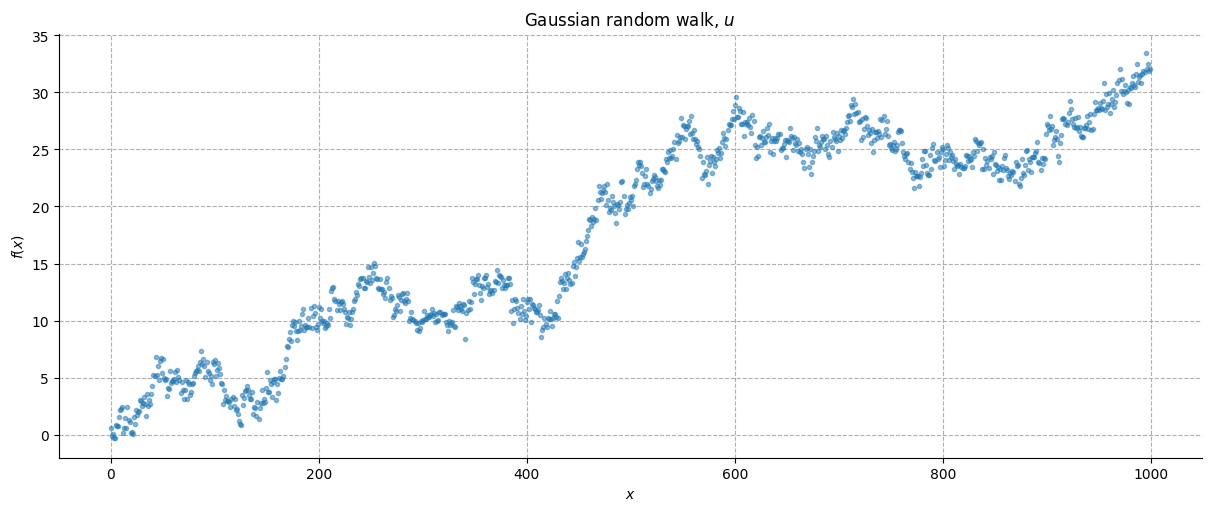

In [3]:
# create u as a Gaussian random walk
low_noise = 0.5
u_1 = np.cumsum(np.random.normal(0.03, 0.5, 1000)) + np.random.normal(
    0.01, low_noise, 1000
)

# plot the signal
_, ax = plt.subplots(figsize=(12, 5))
ax.plot(u_1, marker=".", alpha=0.5, linestyle="")
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$", title=r"Gaussian random walk, $u$")
ax.grid(linestyle="--")
sns.despine()

Imagine that this behaviour constitutes a signal of a given underlying phenomenon. Now, we want to measure the same phenomenon with another instrument that above an arbitrary threshold $a$ can track the signal $u_2$, but below that threshold just gives us some noise. This measurement $u_1$ is supposed to be also noisier than the underlying signal.

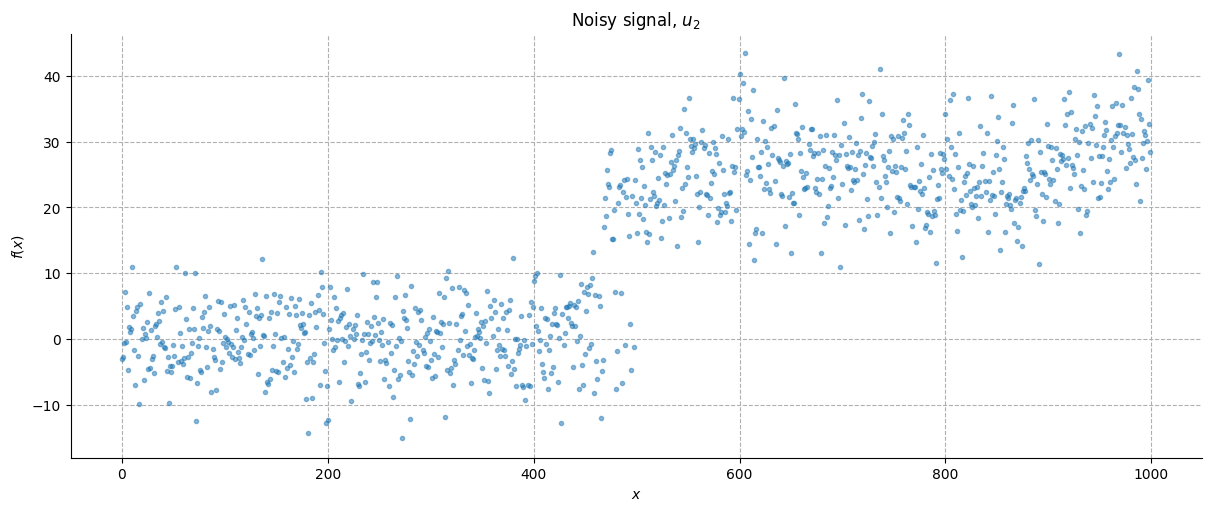

In [4]:
high_noise = 5
a = 20  # setting an arbitrary threshold
u2 = u_1 - (u_1 * (u_1 < a).astype(int)) + (np.random.normal(0, high_noise, 1000))

# plot the signal
_, ax = plt.subplots(figsize=(12, 5))
ax.plot(u2, marker=".", alpha=0.5, linestyle="")
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$", title=r"Noisy signal, $u_2$")
ax.grid(linestyle="--")
sns.despine()

The [ReLU (rectified linear unit) activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) is commonly used in artificial neural networks and is defined as the non-negative part of its argument:

$$
f(x) = 
\begin{cases} 
\ x & \text{for } x > 0 \\
 0 & \text{for } x \leq 0 
\end{cases}
$$

```{figure} https://upload.wikimedia.org/wikipedia/commons/4/42/ReLU_and_GELU.svg
```



If we know the underlying dynamic of the original signal ($u_2$), can we build an HGF network capable of using this information to predict the behaviour of the measured signal ($u_1$)?

Yes, through non-linear coupling! 

Imagine a network in which a value parent node $x_2$ receives information both from a continuous input node registering $u_2$ and a child node $x_1$ connected to another continuous input node registering $u_1$. Then we can calculate $x_2$ and $x_1$ as follows.

$$
x_2^{(k)} \sim Normal(\lambda_2x_2^{(k-1)}, \theta_2)\\
x_1^{(k)} \sim Normal(g_{2,1}(x_2^{(k)})), \theta_1)
$$

where $\lambda$ is the autoconnection strength and $\theta$ the tonic volatility of each node. Note that the autoconnection strength of $x_1$ is set to 0, so that the node mean is informed just by $g_{2,1}(x_2^{(k)})$, being $g_{2,1}$ the coupling function between $x_2$ and $x_1$. This allows us to couple the two nodes without $x_1^{(k)}$ being influenced by its previous state.

We now create first a network structure with all linear couplings ($g_{2,1}$ is the identity function), and then the same structure with a non-linear coupling.

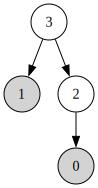

In [5]:
linear_hgf = (
    Network()
    .add_nodes(precision=1 / high_noise**2)  # u1 - Continuous node 0
    .add_nodes(precision=1 / (low_noise) ** 2)  # u2 - Continuous node 1
    .add_nodes(value_children=0, n_nodes=1, autoconnection_strength=0)  # x1 - node 2
    .add_nodes(
        value_children=[1, 2],
        n_nodes=1,
    )  # x2 - node 3
)
linear_hgf.plot_network()

In order to implement the non-linear coupling, we need to specify a coupling function $g_{2,1}$. In this case, we need a function that allows $x_1$ to predict that the input signal below a threshold will be just random noise, but above the threshold is equal to the behaviour displayed by $u_2$.

We can therefore shape the function as follows:

$$
\begin{cases} 
\ u_2 & \text{for } x > a \\
 0 & \text{for } x \leq a 
\end{cases}
$$

For now, we are fixing the parameters knowing how the signal is generated.


In [6]:
# Creating the functions
def g(x, a=20):
    return lax.cond(x > a, lambda x: x, lambda x: 0.0, x)

It is then possible to input the function into the parent node, using the argument `coupling_fn`, that accepts tuples. 
When `coupling_fn` is not specified, the coupling is assumed to be linear (identity function) and the argument passes a `None` tuple, where the number of `None` element matches the number of value children.
If the value parent, as in this case, possesses multiple children, all the functions must be inputed in the same order the value children are declared in the `value_children` argument. To input an identity function it is possible to write `None`.

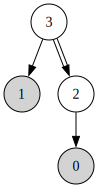

In [7]:
nonlinear_hgf = (
    Network()
    .add_nodes(precision=10.0)  # u1 - Continuous node 0
    .add_nodes(precision=10.0)  # u2 - Continuous node 1
    .add_nodes(value_children=0, n_nodes=1, autoconnection_strength=0)  # x1 - node 2
    .add_nodes(
        value_children=[1, 2], n_nodes=1, coupling_fn=(None, g)
    )  # x2 - node 3 - coupling functions expressed
)
nonlinear_hgf.plot_network()

Let's see how our two networks perform when we input the data.

In [8]:
# data input
input_data = input_data = np.array([u_1, u2]).T

In [9]:
linear_hgf = linear_hgf.input_data(input_data=input_data)

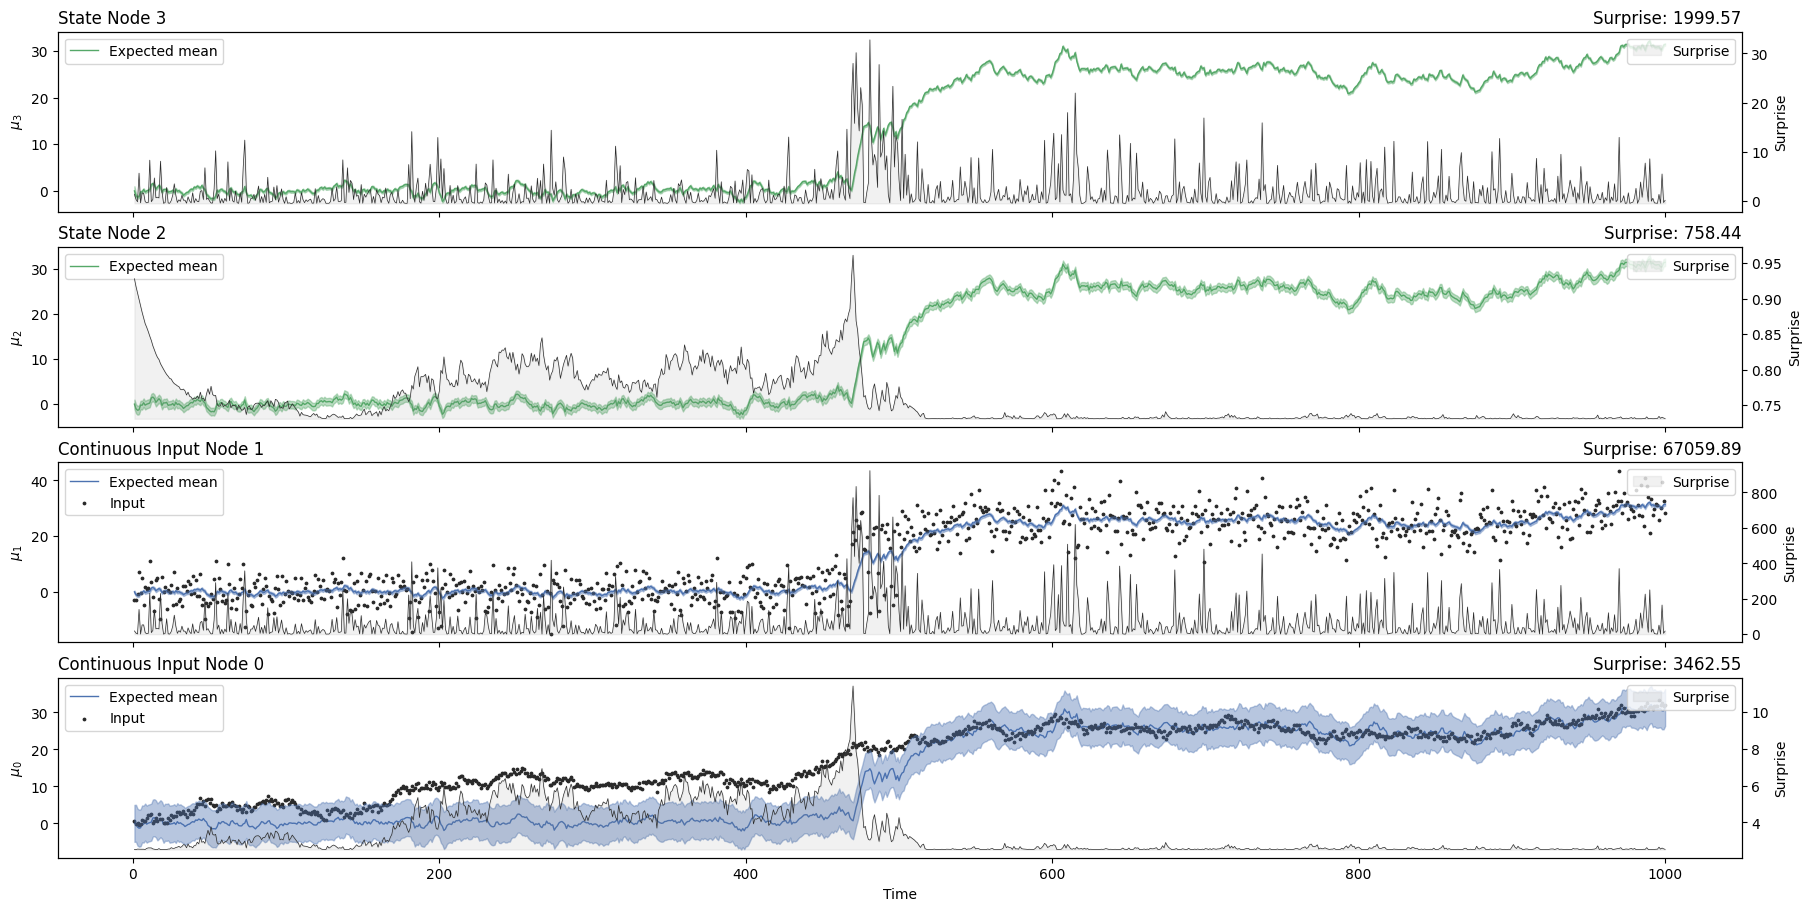

In [10]:
# plot traces
linear_hgf.plot_trajectories();

In [11]:
nonlinear_hgf = nonlinear_hgf.input_data(input_data=input_data)

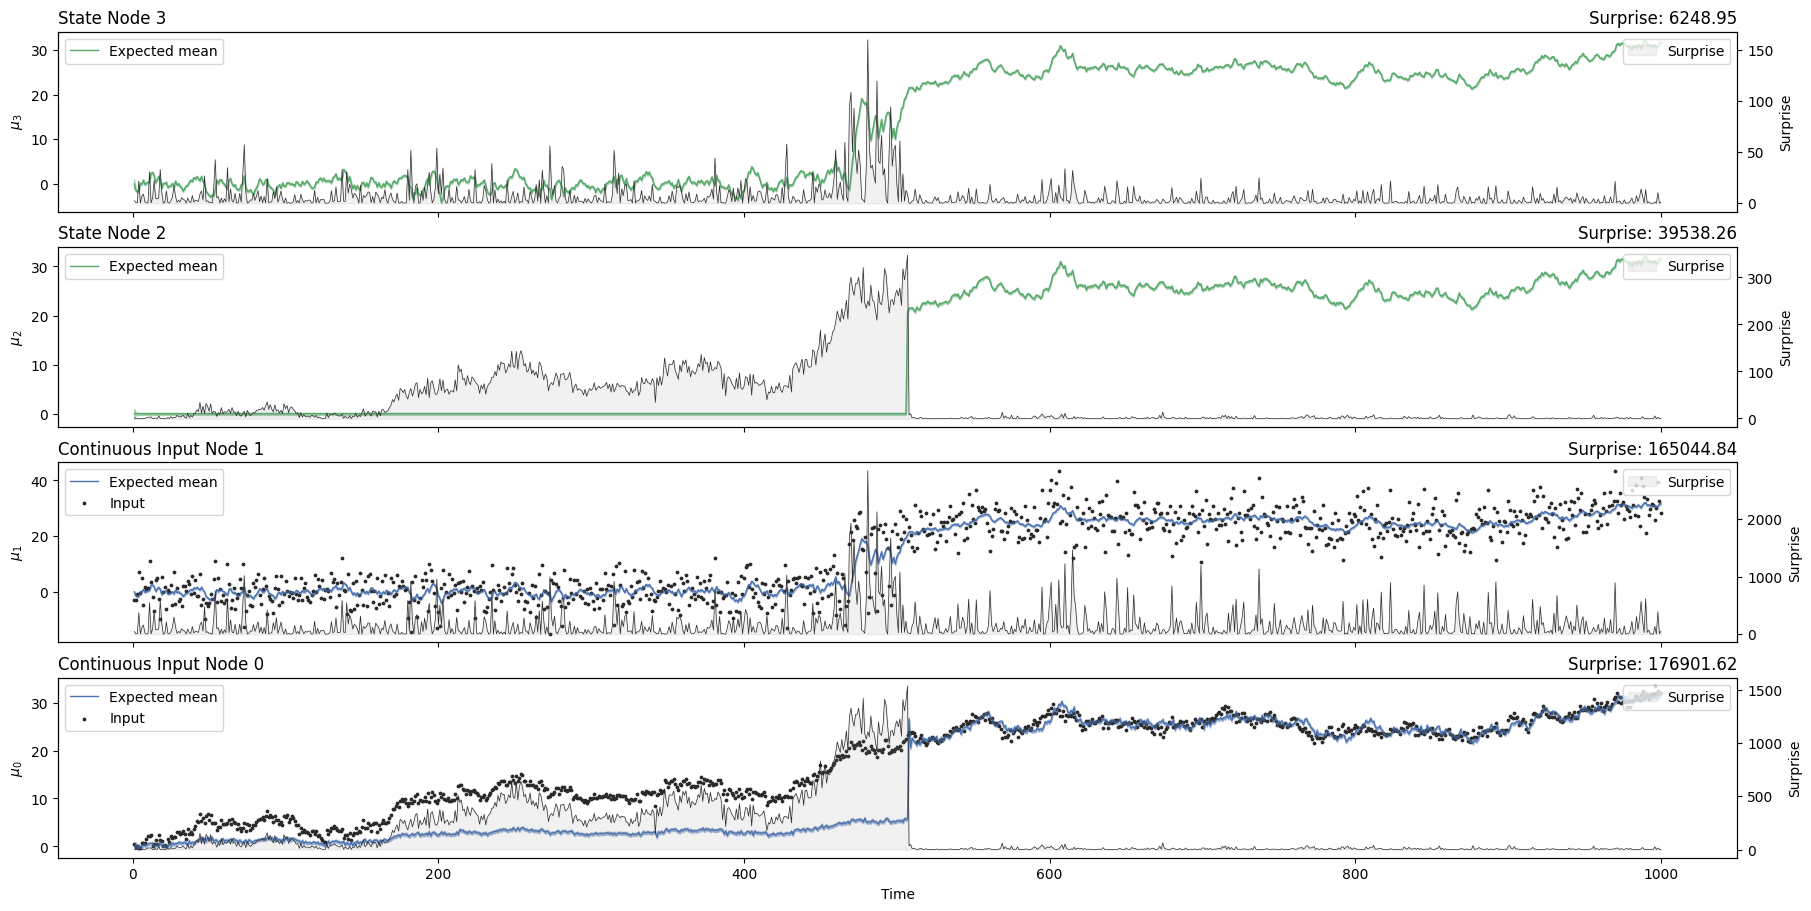

In [12]:
nonlinear_hgf.plot_trajectories();

Let's have a closer look at the behaviour of $x_1$ ("State node 2" in the plot).

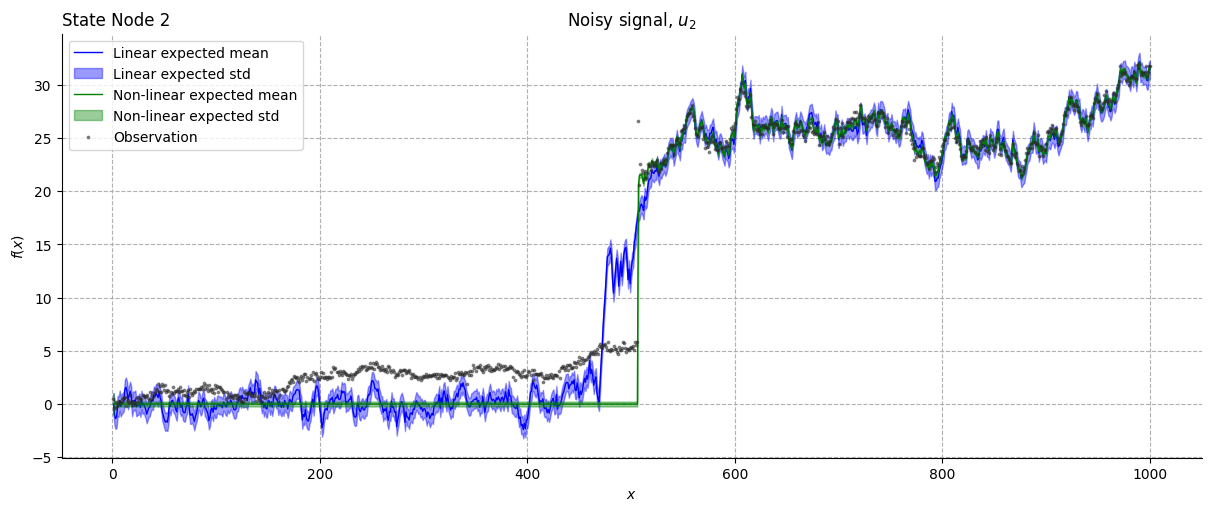

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

linear_hgf.plot_nodes(2, axs=ax, color="blue", show_surprise=False)
nonlinear_hgf.plot_nodes(
    2, axs=ax, color="green", show_surprise=False, show_posterior=True
)
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$", title=r"Noisy signal, $u_2$")
ax.grid(linestyle="--")
ax.legend(
    [
        "Linear expected mean",
        "Linear expected std",
        "Non-linear expected mean",
        "Non-linear expected std",
        "Observation",
    ]
)
sns.despine();

Notice how the HGF manages to track the gaussian random walk even with the linear coupling. However, it is using data coming from $u_2$ to inform $x_1$ state through the value parent $x_2$ even below the threshold, something that in this specific example is incorrect, as $u_1$ behaviour is non-linear and depends on a threshold. Providing a coupling function allows us to use the information coming from $u_2$ just when needed, allowing a more precise tracking.

# Non-linear predictions

Non-linear coupling functions can be used also to build networks able to track in real time the oscillation frequency of sinusoidal waves.

Let's simulate an oscillatory signal with some noise.

In [14]:
np.random.seed(42)
x = np.arange(0, 1000)
std = 0.1
input_data = np.sin(x / 20) + np.random.normal(0, std, 1000)  # sinusoid + noise

We would like to build a network capable of predicting that the signal is oscillating, even when it is not given new observations. When using a linear HGF, if observations are not given, the update function will continue running setting the prediction error $\delta$ to zero.

This means that the predicted mean ($\mu_a$) of a node will depend just on its prediction mean ($\hat{\mu_a}$), that depends on the degree of autocorrelation and the total predicted drift ($P_a$).
$$
\mu_a^{(k)} = \lambda_a \cdot \mu_a^{(k-1)} + P_a\\
P_a = t^{(k)} \cdot (\rho_a + \alpha_{b,a}g_{b,a}(\mu_b^{(k-1)}))
$$
where $t$ is the timestep, $\alpha$ the coupling strength, and $\rho$ tonic drift. Notice that the timestep is coded outside the coupling function (this information will come in handy for the non-linear coupling).

With a linear coupling the predicted mean will just keep drifting, while the precision will progressively increase, as you can see in this example.

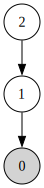

In [15]:
sinusoid_linear_hgf = (
    Network()
    .add_nodes(precision=1 / std**2)  # input
    .add_nodes(value_children=0, n_nodes=1, autoconnection_strength=1)  # x1 - node 1
    .add_nodes(
        value_children=1,
        n_nodes=1,
    )  # x2 - node 2
)
sinusoid_linear_hgf.plot_network()

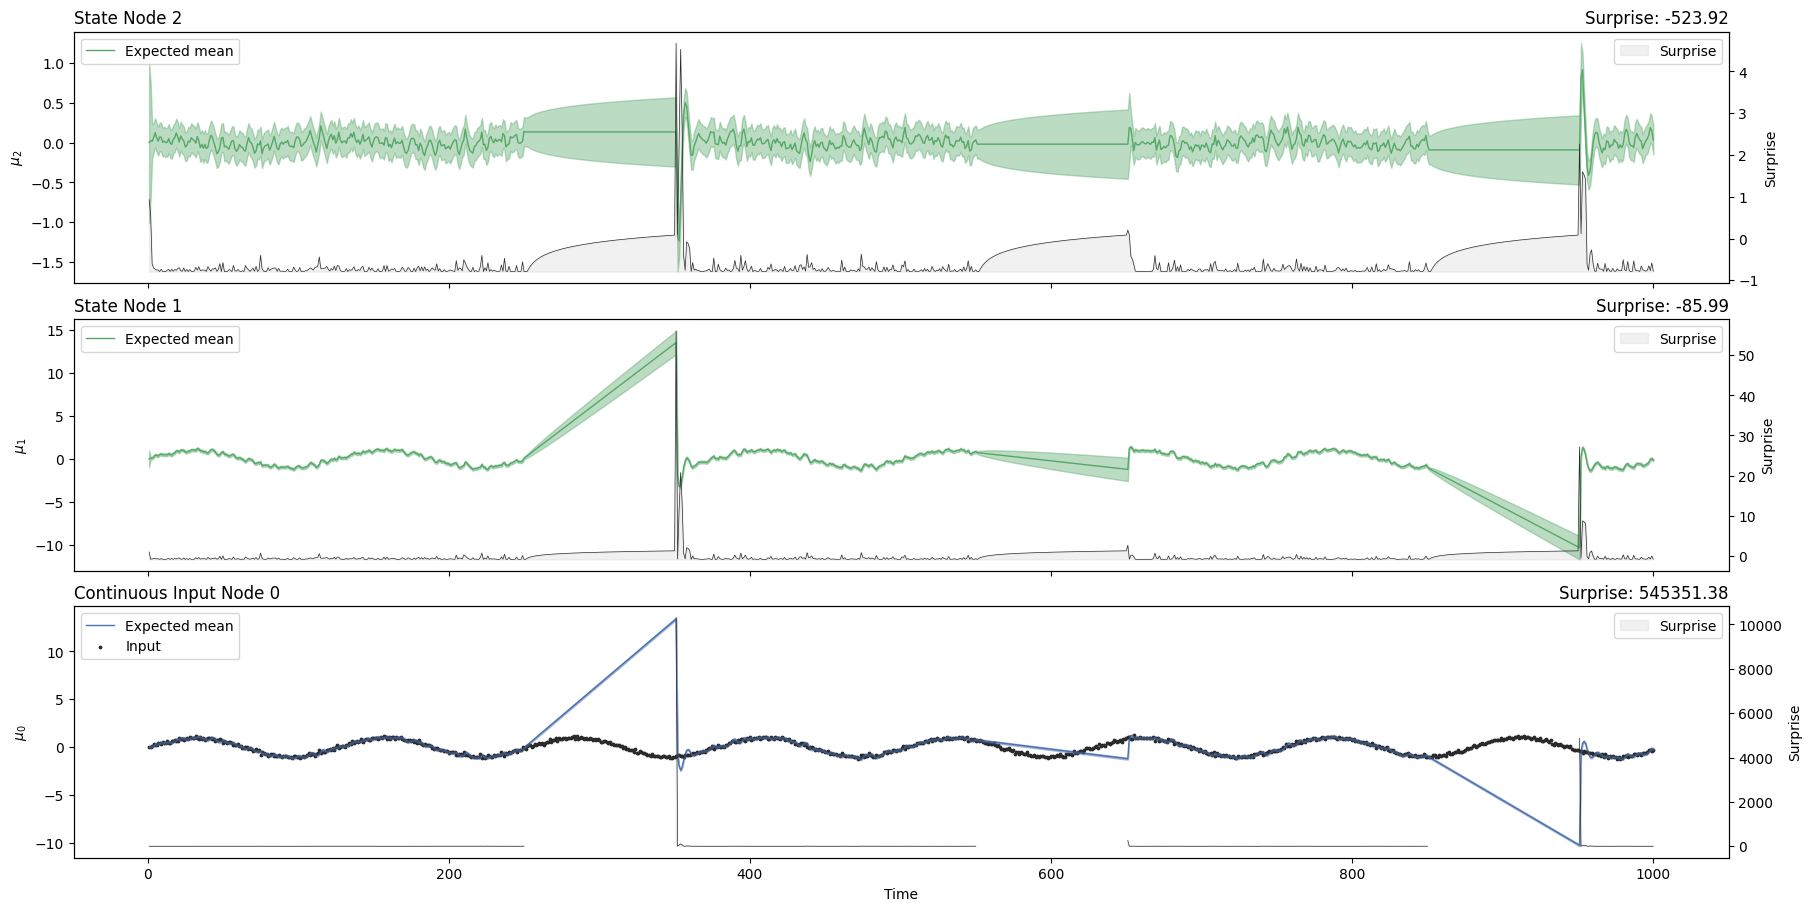

In [16]:
# input data assuming that some chuncks of observations are missing
observed = np.ones(1000)
observed[250:350] = 0
observed[550:650] = 0
observed[850:950] = 0

sinusoid_linear_hgf = sinusoid_linear_hgf.input_data(input_data, observed=observed)

# plot traces
sinusoid_linear_hgf.plot_trajectories();

In [17]:
sinusoid_linear_hgf.input_idxs

(0,)

Notice how $\mu_1$ is just drifting during the missing observation chuncks.

If we want to implement a non-linear HGF capable of tracking a sinusoidal mean, we can't just update the coupling function using the same structure, as the $g$ appears only in the total predicted drift, and will just vary, at best, the steepness of the drift slope.

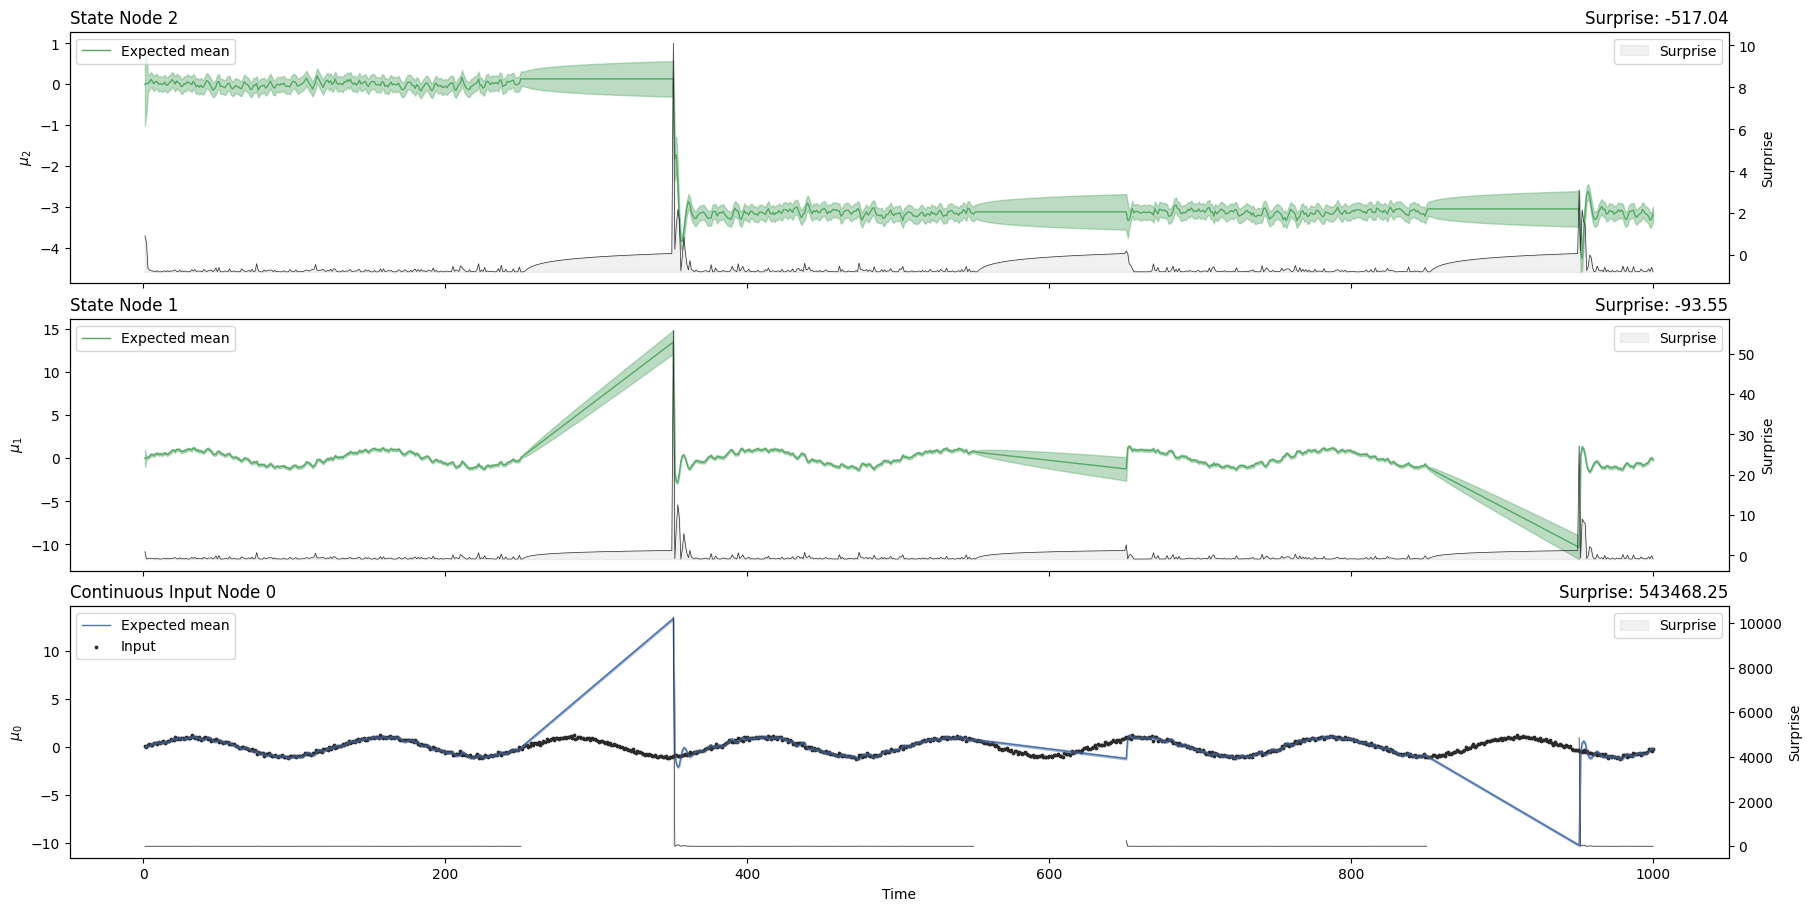

In [18]:
sinusoid_nonlinear_hgf = (
    Network()
    .add_nodes(precision=1 / std**2)  # input
    .add_nodes(value_children=0, n_nodes=1, autoconnection_strength=1)  # x1 - node 1
    .add_nodes(value_children=1, n_nodes=1, coupling_fn=(jnp.sin,))  # x2 - node 2
)
sinusoid_nonlinear_hgf = sinusoid_nonlinear_hgf.input_data(
    input_data, observed=observed
)

# plot traces
sinusoid_nonlinear_hgf.plot_trajectories();

This happens because time is not included directly inside $g$, a fact that doesn't allow the transformation of all the terms from the native space to the sinusoidal space.
A way to overcome this limitation is assuming constant time steps and setting a parent $x_2$ as an "internal clock", and adding a drift parent $x_3$ that can learn the oscillation frequency (when the frequency is varying during time).

$$
\mu_3^{(k)} = \lambda_3 \cdot \mu_3^{(k-1)} + t^{(k)} \cdot (\rho_3)\\
\mu_2^{(k)} = \lambda_2 \cdot \mu_2^{(k-1)} + t^{(k)} \cdot (\rho_2 + \alpha_{3,2}(\mu_3^{(k-1)}))\\
\mu_1^{(k)} =  t^{(k)} \cdot (\alpha_{2,1}g_{b,a}(\mu_2^{(k-1)}))
$$

In this way, given $t^{(k)}$ constant, $\mu_1^{(k)}$ will depend just on $g_{b,a}(\mu_2^{(k-1)})$. If $\mu_2$ represents the time passing as a line, steeper slopes will indicate increased frequencies of oscillation. The steepness of the slope can be learnt by the drift parent when the oscillation frequency is variable.


To understand the dependency of the oscillating frequency of $x_1$ from the slope of $x_2$, consider having a signal with a fixed frequency.
The drift corresponds to the slope of $\mu_2(t)$, which equals to $1/f$, being $f/2\pi$ the oscillation frequency.

In [19]:
sinusoid_nonlinear_hgf = (
    Network()
    .add_nodes(
        precision=1 / std**2
    )  # u1 - Continuous node 0
    .add_nodes(value_children=0, autoconnection_strength=0)  # x1 - node 1
    .add_nodes(
        value_children=1,
        tonic_drift=0.05,  # fixed drift
        autoconnection_strength=1,
        coupling_fn=(jnp.sin,),
    )  # x2 - node 2
)

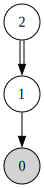

In [20]:
sinusoid_nonlinear_hgf.plot_network()

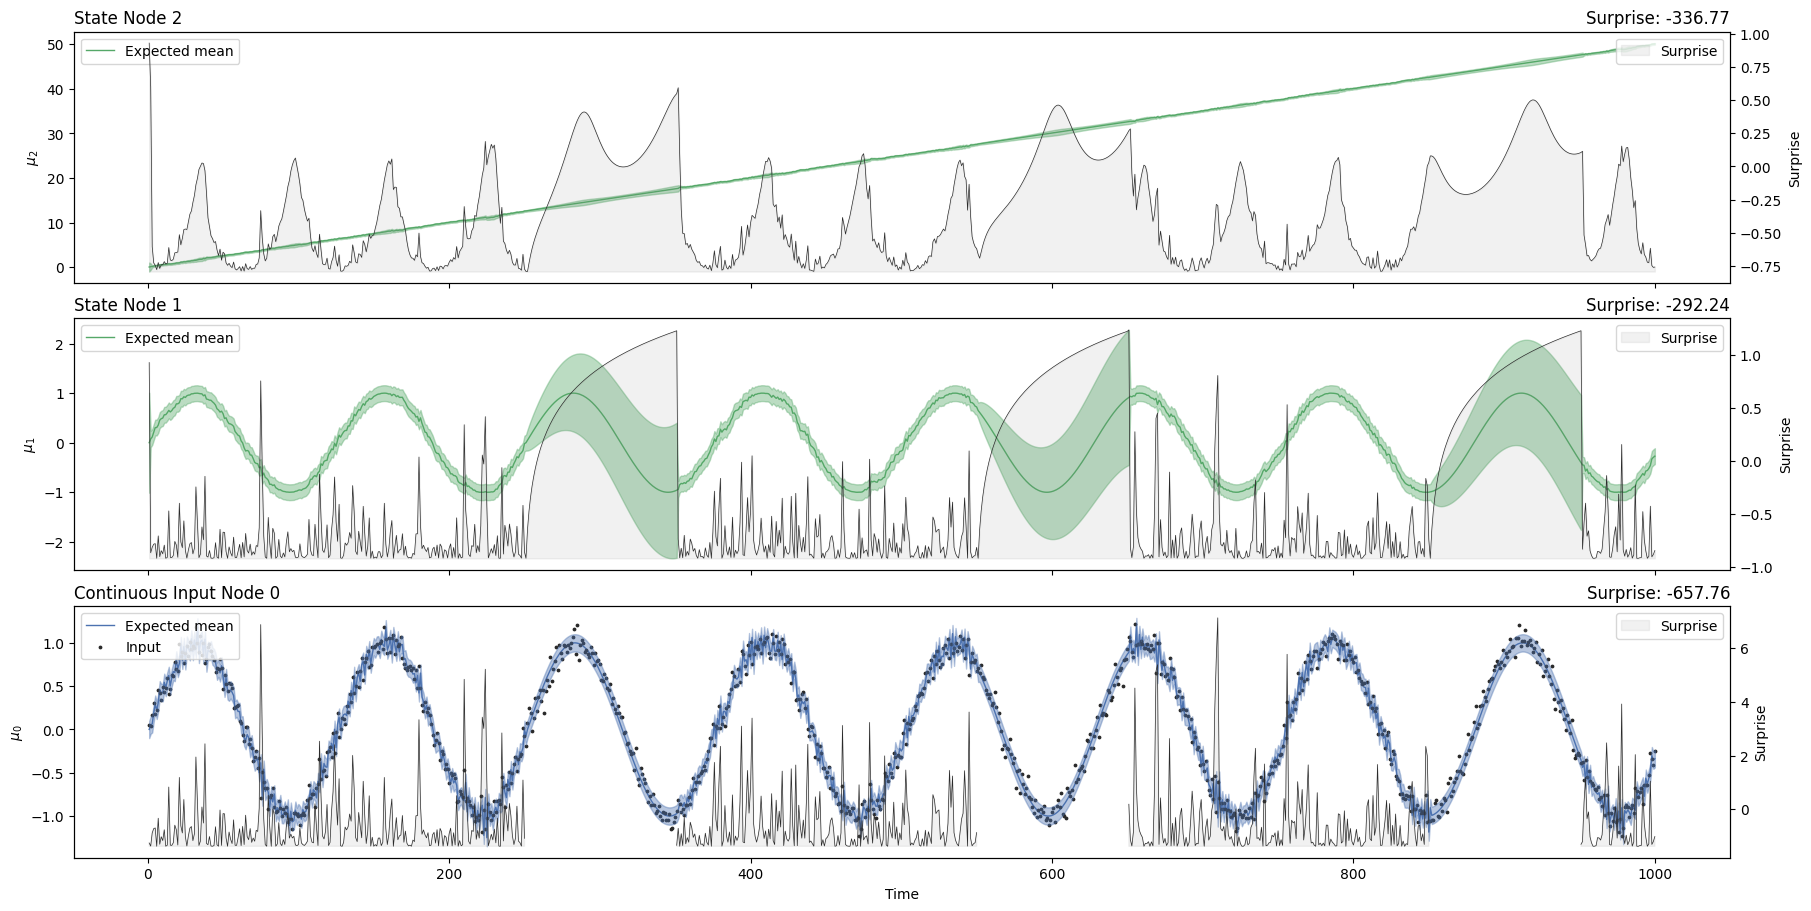

In [21]:
sinusoid_nonlinear_hgf = sinusoid_nonlinear_hgf.input_data(
    input_data, observed=observed
)
sinusoid_nonlinear_hgf.plot_trajectories();

# Frequency tracking

We have shown that a constand drift correspond to a constant oscillation frequency. What if we want our network to learn the oscillation frequency changing over time? We can add a drift parent $x_3$ to inform the slope of $x_2$.

In [22]:
np.random.seed(42)
x = np.ones(1000)
x[400:600] = (
    5  # this parameter sets the frequency of the central part of the sinusoid wave
)
x = np.cumsum(x)
std = 0.1

input_data = np.sin(x / 20) + np.random.normal(0, std, 1000)  # sinusoid + noise

In [23]:
sinusoid_nonlinear_hgf = (
    Network()
    .add_nodes(
        precision=1 / std**2
    )  # u1 - Continuous node 0
    .add_nodes(value_children=0, autoconnection_strength=0)  # x1 - node 1
    .add_nodes(
        value_children=1, mean=0.0, autoconnection_strength=1, coupling_fn=(jnp.sin,)
    )  # x2 - node 2
    .add_nodes(
        value_children=2,
        mean=0.0,
        precision=10,
        tonic_volatility=-8,  # you can change this parameter according to how fast the signal is changing
    )  # x3 - node 3
)

In [24]:
sinusoid_nonlinear_hgf = sinusoid_nonlinear_hgf.input_data(
    input_data, observed=observed
)

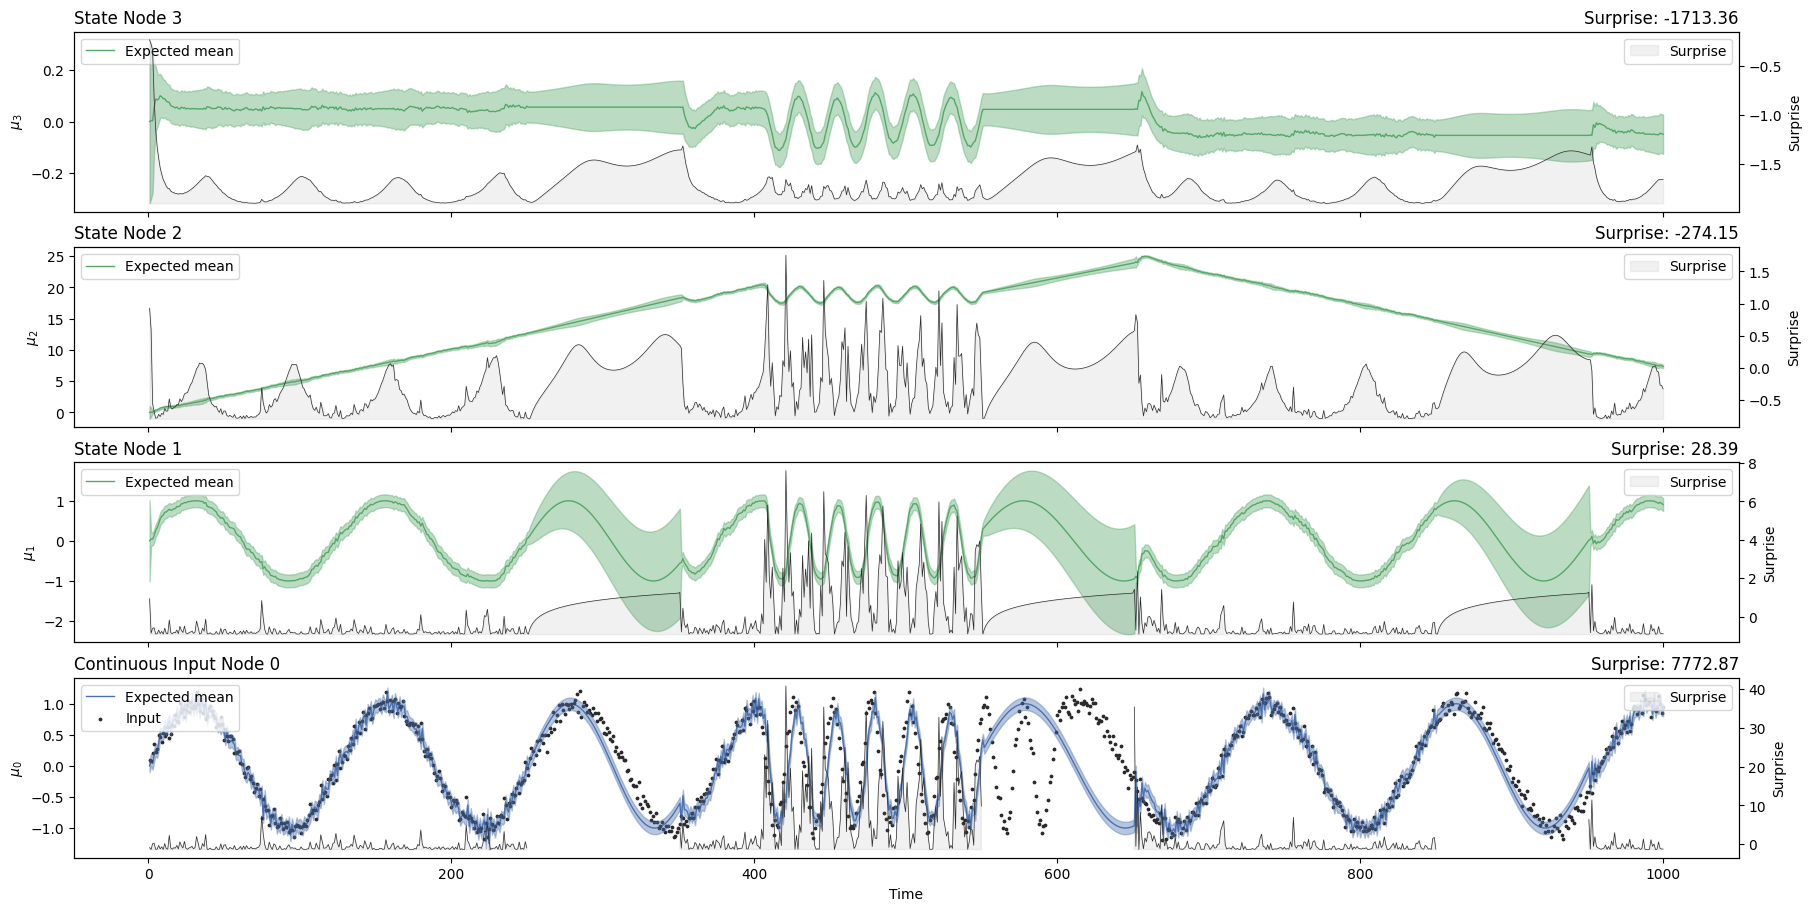

In [25]:
sinusoid_nonlinear_hgf.plot_trajectories();

Zooming on $x_3$, is it possible to observe that higher levels of $\mu_3$ are associated with higher oscillation frequencies ($t=[400:600]$), as predicted. Since no data are given in the interval $t=[600:650]$, the network will not update the oscillation frequency until new data is inputed. 

# System configuration

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Jan 10 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.31.0

pyhgf : 0.2.1.post4.dev0+d49aafe9
jax   : 0.4.31
jaxlib: 0.4.31

seaborn   : 0.13.2
pyhgf     : 0.2.1.post4.dev0+d49aafe9
numpy     : 1.26.0
matplotlib: 3.10.0
jax       : 0.4.31
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
IPython   : 8.31.0

Watermark: 2.5.0

